<a href="https://colab.research.google.com/github/heberthfs/detect-anatomical-marks-located/blob/main/DetectorFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pograma criado por: Hebert Falcao Sales
Objetivo:
Esse programa utiliza Dlib para detectar faces e pontos de interesse em uma imagem. Juntamento utiliza redes neurais de multiplas camadas e suporte vector machine com a abordagem "one vs one" e "one vs all" para classificar seu estado atual dos olhos (aberto/fechado).

Sendo separado em 8 partes.
1. Importação das Biliotecas.
2. Download e importação dos dados.
3. Visualização dos dados.
4. Detecção da face e inserção dos landmarks, tratamento de imagem das faces não detectadas e submissão para nova detecção.
5. Tratamento de Dados.
6. Criação e aplicação de modelos de redes neurais utilizando distâncias entre os landmarks como parâmetro.
7. Criação e aplicação de Modelos com redes neurais  e suporte vector machine utilizando as coordendas das landmarks como parâmetro.
8. Conclusão.



## **1.0 Importação das bibliotecas**

In [403]:
import dlib
import cv2 
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report 
from sklearn.svm import SVC

## **2.0 Importação da base de dados**


In [404]:
!gdown --id "10zMqW1NC1m804vq52zgxjQgh5fcYpDyT" #download ClosedFace.zip
!gdown --id "10EDM4XpvlImdWZ-uwzh0lzfSQIF1q0c7" #download OpenFace.zip 
def extrair(path): #descompatar arquivo de fotos
  zip_object=zipfile.ZipFile(file=path,mode='r')
  zip_object.extractall('./')
  zip_object.close()
extrair('/content/ClosedFace.zip')
extrair('/content/OpenFace.zip')



!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 #download landmarks
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2 #descompatar landmarks
shape_predictor_68_face_landmarks =  "/content/shape_predictor_68_face_landmarks.dat"

Downloading...
From: https://drive.google.com/uc?id=10zMqW1NC1m804vq52zgxjQgh5fcYpDyT
To: /content/ClosedFace.zip
5.75MB [00:00, 90.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=10EDM4XpvlImdWZ-uwzh0lzfSQIF1q0c7
To: /content/OpenFace.zip
3.20MB [00:00, 100MB/s]
--2021-03-13 00:50:42--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  5.37MB/s    in 34s     

2021-03-13 00:51:16 (1.78 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bunzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.


In [405]:
def load_images_from_folder(folder): #carregar imagens
  images = []
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    if img is not None:
      images.append(img)
  return images
closedFace=np.array(load_images_from_folder('/content/ClosedFace')) #variavel com as fotos de olhos fechados
openFace=np.array(load_images_from_folder('/content/OpenFace')) # variavel com as fotos de olhos abertos

##**3.0 Visualização dos dados**

### Grades de visualização de fotos

In [473]:
def imageGrid(images,text):#impimir grade de imagens aleatorias
  width_grid=5
  height_grid=3
  print(text)
  fig,axes=plt.subplots(height_grid,width_grid,figsize=(10,10))
  axes=axes.ravel()
  images.shape[0]
  for i in np.arange(0,width_grid*height_grid):
    index=np.random.randint(0,images.shape[0])
    axes[i].imshow(images[index].reshape((100,100)),'gray')
    axes[i].axis('off')
    plt.subplots_adjust(hspace=0.4)
    
  plt.show()

Sample of eyes closed images


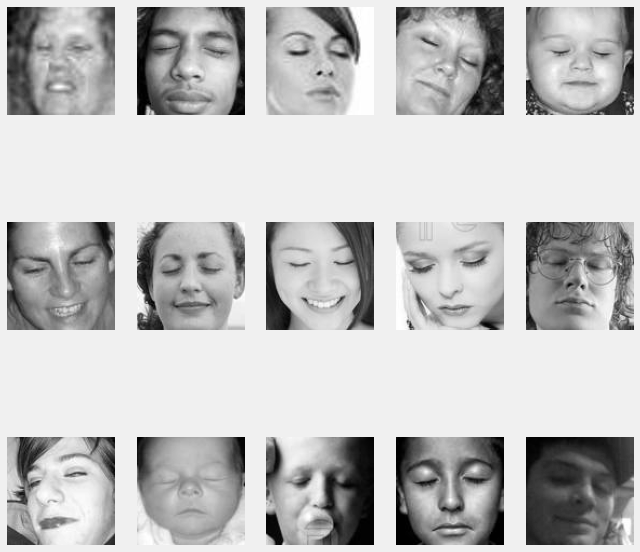

In [474]:
imageGrid(closedFace,"Sample of eyes closed images") 

Sample of open eyes images


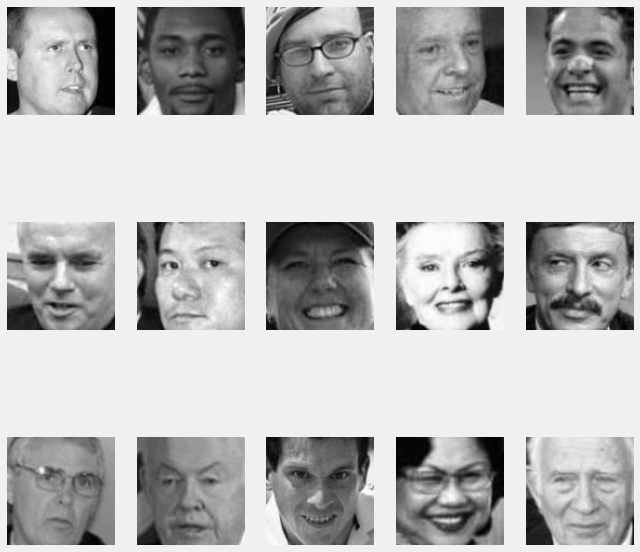

In [475]:
imageGrid(openFace,"Sample of open eyes images")

##4.0 Extração da LandMarks

In [476]:
predictor= dlib.shape_predictor(shape_predictor_68_face_landmarks) #função de detectar landmark
detector=dlib.get_frontal_face_detector() #função de detectar face

def getlandmark (img, detectedfaces): #função para extração de landmarks
  imgCopy=img.copy()
  for face in detectedfaces:
    x1=face.left()
    y1=face.top()
    x2=face.right()
    y2=face.bottom()
    #cv2.rectangle(imgCopy,(x1,y1),(x2,y2),(255,0,0),1)
    landmarks=predictor(img,face)
    landmarkPosition=[]
    for n in range(17,48): #landmarks de interesse
      x=landmarks.part(n).x
      y=landmarks.part(n).y
      landmarkPosition=np.append(landmarkPosition,[landmarks.part(n).x,landmarks.part(n).y])
    return landmarkPosition
    

landmarkCoordinateOpenFace=[] #pegando landmarks de enteresse
for i in range(openFace.shape[0]):
  detectedfaces = detector(openFace[i])
  if (np.array(detectedfaces).shape[0]>0): #condicional para garantir que face seja detectada antes de chamar a função para extração de landmarks
    landmarkCoordinateOpenFace.append(getlandmark(openFace[i], detectedfaces));
  else:
    equ=cv2.equalizeHist(openFace[i])#tratamento de imagem utilizando o Histrogram Equalization para fotos cuja as faces não foram reconhecidas
    detectedfaces =(detector(equ))
    if (np.array(detectedfaces).shape[0]>0): #condicional para garantir que face seja detectada antes de chamar a função para extração de landmarks
      landmarkCoordinateOpenFace.append(getlandmark(openFace[i], detectedfaces));

landmarkCoordinateClosedFace=[] #pegando landmarks de enteresse
for i in range(closedFace.shape[0]): 
  img=closedFace[i]
  detectedfaces = detector(img)
  if (np.array(detectedfaces).shape[0]>0):  #condicional para garantir que face seja detectada antes de chamar a função para extração de landmarks
    landmarkCoordinateClosedFace.append(getlandmark(closedFace[i], detectedfaces))
  else:
    equ=cv2.equalizeHist(closedFace[i])#tratamento de imagem utilizando o Histrogram Equalization para fotos cuja as faces não foram reconhecidas
    detectedfaces = detector(img)
    if (np.array(detectedfaces).shape[0]>0):  #condicional para garantir que face seja detectada antes de chamar a função para extração de landmarks
      landmarkCoordinateClosedFace.append(getlandmark(closedFace[i], detectedfaces))

###Visualizar landmark de interesse

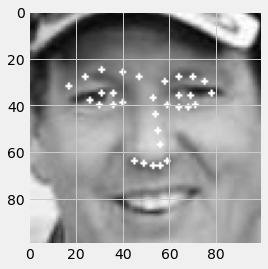

In [477]:
imgCopy=openFace[256].copy()
coordinates=np.array(landmarkCoordinateOpenFace,dtype=int)
for n in range(0,62,2): #landmarks de interesse
  x=coordinates[256,n]
  y=coordinates[256,n+1]
  cv2.circle(imgCopy,(x,y),1,(255,0,0),-1)
plt.imshow(imgCopy,'gray')
plt.show()
 

##**5.0 Tratamento de Dados** 

Visualizar proproção dos dados

proporção dos dados


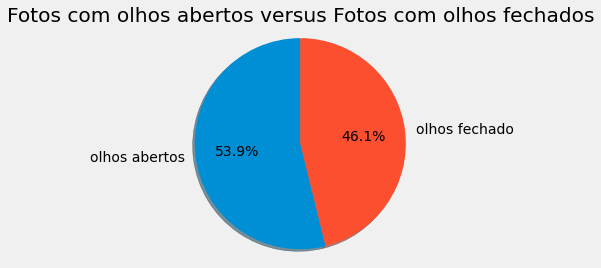

(1027, 62)
(1199, 62)


In [478]:
array1=np.array(landmarkCoordinateOpenFace,dtype=float)
array2=np.array(landmarkCoordinateClosedFace,dtype=float)
sizes=[array1.shape[0],array2.shape[0]]
labels=["olhos abertos","olhos fechado"]

print("proporção dos dados")
plt.title
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set(title="Fotos com olhos abertos versus Fotos com olhos fechados")

plt.show()

print(array2.shape)

print(array1.shape)


Tratamento para deixar as duas amostras do mesmo tamanho

proporção dos dados


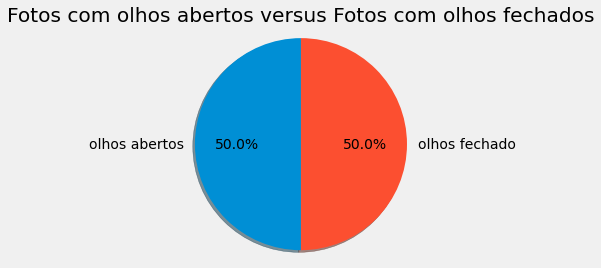

In [479]:
aux=np.zeros(array2.shape,dtype=float)
for i in range(array2.shape[0]):
  aux[i]=landmarkCoordinateOpenFace[i]
landmarkCoordinateOpenFace=np.array(aux,dtype=list)

array1=np.array(landmarkCoordinateClosedFace)
array2=np.array(landmarkCoordinateOpenFace)
sizes=[array1.shape[0],array2.shape[0]]
labels=["olhos abertos","olhos fechado"]

print("proporção dos dados")
plt.title
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set(title="Fotos com olhos abertos versus Fotos com olhos fechados")

plt.show()


In [480]:
def calculateDistance(matriz): #função para calcular as distancias
  matriz=np.array(matriz)
  distances=[]
  aux=0
  i=0
  for i in range(matriz.shape[0]):
    distanceAB=[]
    for j in range(0,62,2):
      Xa=matriz[i,32]
      Ya=matriz[i,33]
      Xb=matriz[i,j]
      Yb=matriz[i,j+1]
      auxiliar=np.sqrt((np.power((Xb-Xa),2)+np.power((Yb-Ya),2)))
      distanceAB=np.append(distanceAB,auxiliar)
    distances.append(distanceAB) 
  return distances

distancesOpenFace=calculateDistance(landmarkCoordinateOpenFace)

distancesClosedFace=calculateDistance(landmarkCoordinateClosedFace)



###Calcular distancias

## 6.0 Criação de modelos utilzando as distancias entre os landmarks como parâmetro

calcular distancia entre landmraks e landmark de refencia 34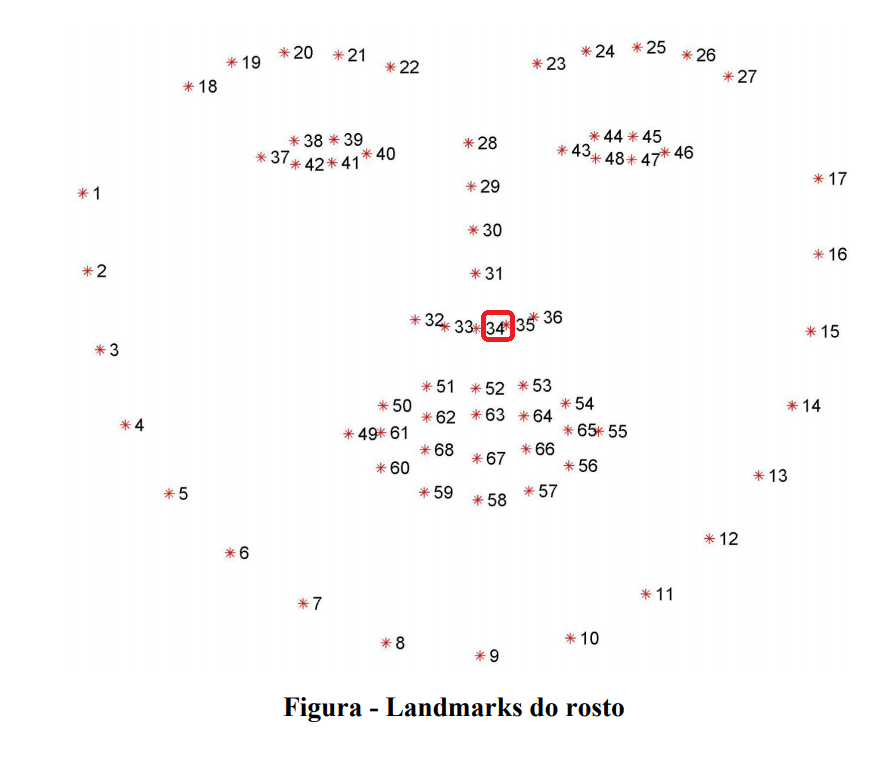


Distancias entre os landmarks das fotos de olhos abertos

In [481]:
dfDistancesOpenFace=pd.DataFrame(distancesOpenFace) #cria dataframe
dfDistancesOpenFace['Eye_Status']='aberto' #adicona coluna "eye_status"
dfDistancesOpenFace.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,Eye_Status
1022,54.037024,53.758720,49.406477,43.416587,37.336309,36.496575,41.761226,47.539457,51.478151,51.613952,26.172505,21.095023,15.033296,9.000000,10.198039,5.099020,0.0,5.385165,8.944272,40.804412,39.597980,35.000000,28.844410,30.413813,35.608988,27.202941,33.241540,36.715120,37.013511,32.802439,28.653098,aberto
1023,50.774009,50.931326,47.201695,42.047592,36.138622,36.124784,39.293765,42.047592,42.201896,38.897301,27.073973,21.023796,16.000000,9.055385,10.198039,5.099020,0.0,4.123106,7.280110,39.408121,37.483330,34.058773,28.017851,31.827661,34.828150,23.769729,28.792360,30.528675,30.479501,27.202941,25.495098,aberto
1024,50.249378,49.769469,46.572524,43.416587,39.000000,39.924930,46.647615,51.224994,55.172457,56.400355,30.594117,22.360680,14.317821,6.082763,9.219544,5.000000,0.0,6.082763,11.180340,39.357337,38.275318,35.902646,31.256999,32.280025,35.341194,33.837849,39.204592,42.426407,43.416587,39.051248,35.383612,aberto
1025,48.010416,50.606324,50.695167,47.539457,44.407207,44.911023,50.921508,55.470713,57.201399,57.280014,31.064449,24.020824,17.000000,10.049876,9.219544,5.099020,0.0,6.082763,12.165525,34.828150,34.985711,32.310989,26.683328,27.730849,30.000000,31.304952,37.735925,41.231056,42.449971,36.769553,32.802439,aberto
1026,48.466483,50.289164,49.030603,46.270941,43.000000,44.598206,50.119856,54.203321,58.000000,60.216277,32.388269,25.079872,17.000000,10.440307,7.211103,4.472136,0.0,5.000000,10.049876,35.468296,36.400549,34.365681,31.016125,31.575307,32.893768,35.000000,39.698866,43.185646,45.221676,40.459857,37.483330,aberto


Distancias entre os landmarks das fotos de olhos fechados

In [482]:
dfDistancesClosedFace=pd.DataFrame(distancesClosedFace) #cria dataframe
dfDistancesClosedFace['Eye_Status']='fechado'#adicona coluna "eye_status"
dfDistancesClosedFace.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,Eye_Status
1022,50.328918,51.088159,48.877398,44.944410,40.792156,40.792156,44.944410,49.739320,51.739733,51.088159,28.000000,21.000000,16.000000,10.000000,8.062258,4.000000,0.0,4.000000,8.062258,35.608988,32.526912,29.410882,25.942244,27.802878,31.144823,25.942244,30.000000,32.526912,36.400549,31.827661,28.425341,fechado
1023,48.259714,46.957428,43.011626,39.623226,35.000000,34.014703,38.275318,42.520583,45.343136,46.043458,27.459060,20.396078,12.369317,5.385165,8.602325,4.472136,0.0,5.099020,9.219544,35.846897,34.014703,31.320920,28.442925,29.732137,32.649655,27.294688,29.206164,31.827661,34.205263,29.732137,27.018512,fechado
1024,46.400431,47.507894,45.694639,42.449971,38.470768,39.217343,44.283180,48.259714,50.249378,51.088159,28.071338,21.023796,14.000000,7.280110,8.944272,4.472136,0.0,5.099020,9.219544,32.802439,30.016662,28.231188,25.961510,27.730849,29.681644,28.844410,31.240999,33.970576,36.400549,32.557641,29.732137,fechado
1025,66.603303,65.192024,59.908263,53.225934,47.127487,44.181444,48.764741,54.626001,58.830264,58.258047,34.132096,25.079872,16.031220,7.000000,13.341664,6.082763,0.0,6.324555,11.704700,51.088159,46.690470,42.801869,37.215588,40.459857,45.276926,33.241540,37.576588,40.816663,43.416587,38.832976,35.777088,fechado
1026,47.010637,48.083261,46.400431,43.416587,39.560081,40.112342,44.911023,48.104054,49.244289,50.606324,28.284271,21.377558,14.317821,7.280110,9.219544,5.099020,0.0,4.472136,9.433981,34.409301,31.144823,29.068884,26.419690,27.658633,30.479501,26.925824,29.546573,31.906112,36.235342,32.449961,29.068884,fechado


In [483]:
distances=pd.concat([dfDistancesClosedFace,dfDistancesOpenFace],ignore_index=True)
distances=distances.dropna(axis=1, how='all') # deleta coluna em que todos os valores são 0

### Dividir conjunto de dados
Dividir conjunto de dados separando aleatoriamente 75% da instancia de treino e 25% para validação

In [484]:
previsores=distancias.iloc[:,0:31]
classe=distancias.iloc[:,31]
x_train, x_test,y_train,y_test=sk.model_selection.train_test_split(previsores,classe,train_size=0.75,random_state=0)

### Construção do modelo Multi-layer Perceptron (MLP) para analisar as distancias

função para criação de matrix confução

In [485]:
def show_info(result, correct, classes=None):
  matrix = confusion_matrix(correct, result)
  print('Total Erros:', (correct!=result).sum())
  print('Acurácia:', np.trace(matrix) / len(correct) * 100)
  print('Matriz de Confusão:')
  return pd.DataFrame(matrix, classes, classes)

####MLP usando a funcão de ativação relu

In [486]:
classifier=MLPClassifier(hidden_layer_sizes=([200,200,200]),verbose=False, max_iter=200,activation="relu")
classifier.fit(x_train,y_train)  
predictions=classifier.predict(x_test)

matriz confução

In [487]:
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 70
Acurácia: 87.41007194244604
Matriz de Confusão:


,aberto,fechado
aberto,285,7
fechado,63,201


In [488]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.82      0.98      0.89       292
     fechado       0.97      0.76      0.85       264

    accuracy                           0.87       556
   macro avg       0.89      0.87      0.87       556
weighted avg       0.89      0.87      0.87       556



####MLP usando a funcão de ativação "identity"

In [489]:
classifier=MLPClassifier(hidden_layer_sizes=([200,200,200]),verbose=False, max_iter=200,activation="identity")
classifier.fit(x_train,y_train)  
predictions=classifier.predict(x_test)

In [490]:
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 70
Acurácia: 87.41007194244604
Matriz de Confusão:


,aberto,fechado
aberto,244,48
fechado,22,242


In [491]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.92      0.84      0.87       292
     fechado       0.83      0.92      0.87       264

    accuracy                           0.87       556
   macro avg       0.88      0.88      0.87       556
weighted avg       0.88      0.87      0.87       556



##7.0 **Criação de modelos para a análise das coordenadas dos landmarks**
Coordenada dos landmarks para Aplicação no modelo SVM

coordendas olhos fechados:

In [492]:
dfClosedFace=pd.DataFrame(landmarkCoordinateClosedFace)
dfClosedFace['Eye_Status']='fechado'
dfClosedFace.head(10)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,Eye_Status
0,9.0,26.0,16.0,23.0,24.0,23.0,32.0,25.0,39.0,28.0,57.0,28.0,64.0,24.0,71.0,22.0,78.0,21.0,85.0,23.0,49.0,37.0,49.0,45.0,50.0,52.0,51.0,60.0,43.0,63.0,47.0,64.0,50.0,65.0,54.0,64.0,57.0,63.0,19.0,40.0,24.0,40.0,30.0,40.0,35.0,39.0,30.0,41.0,24.0,42.0,61.0,38.0,66.0,39.0,71.0,39.0,76.0,39.0,72.0,40.0,67.0,40.0,fechado
1,11.0,39.0,17.0,33.0,26.0,30.0,35.0,31.0,45.0,33.0,54.0,34.0,62.0,30.0,71.0,29.0,79.0,32.0,85.0,37.0,49.0,40.0,50.0,48.0,50.0,56.0,51.0,65.0,42.0,69.0,46.0,70.0,50.0,71.0,54.0,70.0,58.0,69.0,22.0,43.0,27.0,41.0,33.0,40.0,39.0,43.0,34.0,45.0,27.0,46.0,58.0,42.0,64.0,39.0,71.0,40.0,75.0,42.0,71.0,45.0,64.0,45.0,fechado
2,16.0,27.0,23.0,24.0,31.0,24.0,39.0,27.0,46.0,31.0,60.0,32.0,68.0,30.0,76.0,29.0,84.0,31.0,89.0,36.0,53.0,39.0,52.0,45.0,52.0,51.0,51.0,58.0,41.0,64.0,45.0,66.0,50.0,67.0,55.0,67.0,59.0,66.0,24.0,39.0,29.0,39.0,34.0,39.0,39.0,40.0,34.0,40.0,29.0,40.0,64.0,42.0,70.0,43.0,75.0,44.0,80.0,45.0,74.0,45.0,69.0,44.0,fechado
3,5.0,26.0,14.0,21.0,23.0,20.0,33.0,20.0,43.0,23.0,60.0,22.0,70.0,20.0,79.0,19.0,88.0,21.0,95.0,26.0,52.0,37.0,53.0,45.0,53.0,53.0,54.0,60.0,43.0,69.0,48.0,70.0,53.0,71.0,57.0,70.0,61.0,69.0,17.0,41.0,23.0,40.0,30.0,40.0,35.0,41.0,29.0,43.0,23.0,43.0,66.0,41.0,73.0,40.0,79.0,41.0,85.0,41.0,79.0,43.0,73.0,43.0,fechado
4,13.0,26.0,18.0,23.0,26.0,23.0,33.0,26.0,40.0,29.0,57.0,29.0,64.0,25.0,72.0,22.0,80.0,22.0,87.0,25.0,48.0,39.0,48.0,48.0,47.0,56.0,47.0,64.0,39.0,68.0,43.0,69.0,48.0,71.0,53.0,69.0,57.0,68.0,20.0,39.0,26.0,39.0,31.0,39.0,37.0,40.0,31.0,42.0,25.0,42.0,61.0,40.0,66.0,38.0,72.0,39.0,77.0,39.0,72.0,41.0,66.0,41.0,fechado
5,16.0,32.0,21.0,28.0,27.0,26.0,34.0,27.0,40.0,29.0,56.0,29.0,63.0,26.0,71.0,25.0,78.0,26.0,84.0,30.0,50.0,38.0,50.0,47.0,50.0,56.0,51.0,66.0,42.0,67.0,46.0,69.0,51.0,70.0,56.0,68.0,60.0,66.0,24.0,39.0,28.0,39.0,33.0,39.0,39.0,39.0,33.0,40.0,28.0,41.0,61.0,38.0,66.0,38.0,71.0,38.0,76.0,38.0,71.0,39.0,66.0,39.0,fechado
6,16.0,30.0,22.0,25.0,30.0,22.0,39.0,23.0,47.0,26.0,60.0,28.0,68.0,27.0,77.0,29.0,84.0,33.0,88.0,40.0,51.0,38.0,50.0,43.0,49.0,49.0,48.0,55.0,39.0,60.0,43.0,62.0,47.0,63.0,51.0,63.0,55.0,63.0,26.0,38.0,31.0,37.0,36.0,37.0,40.0,40.0,35.0,40.0,30.0,39.0,62.0,43.0,67.0,42.0,72.0,43.0,76.0,46.0,71.0,45.0,66.0,44.0,fechado
7,16.0,28.0,22.0,24.0,29.0,24.0,37.0,26.0,43.0,29.0,57.0,32.0,66.0,31.0,74.0,32.0,81.0,35.0,87.0,41.0,49.0,39.0,48.0,45.0,47.0,50.0,46.0,55.0,38.0,59.0,41.0,61.0,45.0,62.0,49.0,62.0,54.0,62.0,25.0,37.0,30.0,37.0,34.0,37.0,38.0,39.0,33.0,39.0,29.0,38.0,61.0,43.0,66.0,43.0,70.0,45.0,75.0,46.0,70.0,46.0,65.0,45.0,fechado
8,11.0,30.0,16.0,24.0,24.0,22.0,32.0,23.0,39.0,26.0,55.0,25.0,63.0,21.0,73.0,20.0,82.0,22.0,88.0,28.0,47.0,36.0,47.0,44.0,46.0,52.0,46.0,60.0,39.0,66.0,43.0,67.0,47.0,68.0,51.0,67.0,55.0,66.0,20.0,40.0,25.0,39.0,30.0,39.0,35.0,40.0,30.0,41.0,25.0,41.0,61.0,39.0,66.0,38.0,72.0,39.0,77.0,39.0,72.0,41.0,67.0,41.0,fechado
9,20.0,24.0,25.0,21.0,30.0,22.0,36.0,24.0,41.0,27.0,58.0,29.0,66.0,28.0,73.0,28.0,80.0,31.0,83.0,36.0,48.0,40.0,47.0,47.0,45.0,54.0,44.0,61.0,36.0,64.0,39.0,65.0,43.0,67.0,46.0,67.0,50.0,67.0,23.0,38.0,28.0,39.0,32.0,39.0,37.0,40.0,31.0,41.0,27.0,40.0,60.0,44.0,66.0,45.0,70.0,46.0,74.0,46.0,69.0,47.0,65.0,47.0,fechado


coordenadas olhos abertos

In [493]:
dfOpenFace=pd.DataFrame(landmarkCoordinateOpenFace)
dfOpenFace['Eye_Status']='aberto'
dfOpenFace.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,Eye_Status
0,19,36,23,32,29,30,35,30,41,31,58,31,62,29,67,29,72,30,75,34,51,41,51,49,52,56,53,63,43,66,47,67,52,68,56,67,59,65,27,43,31,41,36,41,39,44,35,45,31,45,58,43,62,40,66,40,69,42,67,44,63,44,aberto
1,9,36,17,32,26,30,36,31,45,34,60,32,66,29,73,26,79,25,83,29,54,40,56,46,58,53,61,60,46,66,53,67,58,68,62,66,66,64,20,42,25,39,32,39,38,42,32,44,25,45,60,40,65,35,71,34,75,36,72,40,66,40,aberto
2,20,33,25,29,30,26,37,26,43,28,56,27,62,24,69,23,75,25,80,28,50,37,50,43,50,50,50,57,45,63,48,64,51,64,55,63,58,62,28,40,32,37,37,37,42,41,37,42,32,42,59,39,63,34,69,34,73,37,69,39,64,40,aberto
3,16,37,20,33,27,32,33,32,40,34,58,32,65,29,72,28,79,28,85,31,50,42,51,50,51,57,52,65,45,69,49,70,53,71,56,69,60,68,25,43,29,40,35,40,40,44,35,46,29,46,62,42,66,37,72,36,77,39,73,42,68,42,aberto
4,18,41,21,36,27,34,33,33,39,34,53,30,59,26,67,23,75,23,83,26,47,40,47,48,48,56,48,64,43,69,47,70,51,70,55,68,60,66,26,46,29,43,34,42,40,44,35,46,30,47,61,40,65,36,70,35,75,37,71,39,66,40,aberto


In [494]:
faces=pd.concat([dfClosedFace,dfOpenFace],ignore_index=True)#concatenar as duas matrizes

In [495]:
faces.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,Eye_Status
2049,11,31,16,26,24,25,32,27,40,30,59,29,65,25,71,21,78,20,83,23,50,39,51,44,52,50,53,56,43,63,48,64,53,65,58,63,61,61,20,41,25,37,32,37,37,41,32,43,25,43,61,39,65,34,71,33,76,36,73,39,67,40,aberto
2050,12,37,18,29,27,26,37,26,46,29,58,28,65,26,73,26,80,30,83,37,53,37,54,43,55,48,56,55,45,62,50,63,55,64,59,63,62,62,23,41,28,38,33,38,39,41,33,41,28,42,61,41,65,37,71,38,75,41,71,42,66,41,aberto
2051,18,29,25,26,32,27,38,29,44,33,59,35,68,32,76,32,84,34,89,38,50,42,48,50,47,58,45,66,37,66,40,69,44,72,50,71,55,70,26,37,31,36,36,37,40,41,35,41,29,40,63,44,68,41,74,42,78,45,74,47,68,46,aberto
2052,19,30,22,25,28,22,35,23,41,25,56,25,64,21,73,20,81,23,88,29,49,38,48,45,47,52,46,59,38,67,42,68,47,69,53,68,59,67,25,42,29,39,35,39,41,43,35,44,29,45,61,41,67,37,73,37,78,40,73,43,67,43,aberto
2053,26,26,29,23,34,23,39,25,44,28,59,29,68,27,77,28,86,31,93,36,49,39,46,46,44,54,41,61,38,67,40,69,44,71,49,71,54,70,31,38,34,36,39,37,43,40,38,40,33,40,65,43,70,41,76,42,81,45,75,45,70,44,aberto


In [496]:
previsores=faces.iloc[:,0:62]
classe=faces.iloc[:,62]
previsores=np.array(previsores)
#utilizando o model selection para validação cruzada


### Dividir conjunto de dados

In [497]:
x_train, x_test,y_train,y_test=sk.model_selection.train_test_split(previsores,classe,train_size=0.75,random_state=0)


### Construção do modelo Multi-layer Perceptron (MLP) para analisar as coordenadas
Dividir conjunto de dados separando aleatoriamente 75% da instancia de treino e 25% para validação

#### MLP usando a funcão de ativação relu

In [498]:
classifier=MLPClassifier(max_iter=200,hidden_layer_sizes=([200,200,200]),verbose=False,activation="relu")
classifier.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[200, 200, 200], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [499]:
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 61
Acurácia: 88.13229571984435
Matriz de Confusão:


,fechado,aberto
fechado,235,13
aberto,48,218


####MLP usando a funcão de ativação "identity"

In [500]:
classifier=MLPClassifier(max_iter=200,hidden_layer_sizes=([200,200,200]),verbose=False,activation="identity")
classifier.fit(x_train,y_train)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[200, 200, 200], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [501]:
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 75
Acurácia: 85.40856031128405
Matriz de Confusão:


,fechado,aberto
fechado,182,66
aberto,9,257


In [502]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.95      0.73      0.83       248
     fechado       0.80      0.97      0.87       266

    accuracy                           0.85       514
   macro avg       0.87      0.85      0.85       514
weighted avg       0.87      0.85      0.85       514



###Criação de modelos SVM

###Modelo SVM na abordagem One vs Rest(ovr)

####SVM ovr kernel linear
definido por:$(x,x`)$ 

In [503]:
svmOvr=SVC(decision_function_shape="ovr",kernel='linear')
classifier=svmOvr.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 37
Acurácia: 92.80155642023347
Matriz de Confusão:


,fechado,aberto
fechado,236,12
aberto,25,241


In [504]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.90      0.95      0.93       248
     fechado       0.95      0.91      0.93       266

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



####SVM ovr kernel poly
definido por: $(\gamma(x,x`)coef)^d$ 

In [505]:
svmOvr=SVC(decision_function_shape="ovr",kernel='poly')
classifier=svmOvr.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 34
Acurácia: 93.3852140077821
Matriz de Confusão:


,fechado,aberto
fechado,237,11
aberto,23,243


In [506]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.91      0.96      0.93       248
     fechado       0.96      0.91      0.93       266

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



####SVM ovr kernel rbf 
definido por: $exp(\gamma  \|x-x` \|^2)$

In [507]:
svmOvr=SVC(decision_function_shape="ovr",kernel='rbf')
classifier=svmOvr.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 73
Acurácia: 85.7976653696498
Matriz de Confusão:


,fechado,aberto
fechado,225,23
aberto,50,216


In [508]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.82      0.91      0.86       248
     fechado       0.90      0.81      0.86       266

    accuracy                           0.86       514
   macro avg       0.86      0.86      0.86       514
weighted avg       0.86      0.86      0.86       514



### Modelo SVM na abordagem One vs One(ovo)

#### SVM ovo kernel linear
definido por:$(x,x`)$  

In [509]:
svmOvo=SVC(decision_function_shape="ovo",kernel='linear')
classifier=svmOvo.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 37
Acurácia: 92.80155642023347
Matriz de Confusão:


,fechado,aberto
fechado,236,12
aberto,25,241


In [510]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.90      0.95      0.93       248
     fechado       0.95      0.91      0.93       266

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



####SVM ovo kernel poly
definido por: $(\gamma(x,x`)coef)^d$ 

In [511]:
svmOvo=SVC(decision_function_shape="ovo",kernel='poly')
classifier=svmOvo.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix

Total Erros: 34
Acurácia: 93.3852140077821
Matriz de Confusão:


,fechado,aberto
fechado,237,11
aberto,23,243


In [512]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.91      0.96      0.93       248
     fechado       0.96      0.91      0.93       266

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



####SVM ovr kernel rbf 
definido por: $exp(\gamma  \|x-x` \|^2)$

In [513]:
svmOvo=SVC(decision_function_shape="ovo",kernel='rbf')
classifier=svmOvo.fit(x_train,y_train)
predictions=classifier.predict(x_test)
cofusion_matrix=show_info(predictions,y_test,y_train.unique())
cofusion_matrix


Total Erros: 73
Acurácia: 85.7976653696498
Matriz de Confusão:


,fechado,aberto
fechado,225,23
aberto,50,216


In [514]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      aberto       0.82      0.91      0.86       248
     fechado       0.90      0.81      0.86       266

    accuracy                           0.86       514
   macro avg       0.86      0.86      0.86       514
weighted avg       0.86      0.86      0.86       514



# **8.0 Conclusão**
  Pode-se considerar um empate tecnico entre os modelos SVM ovo e SVM ovr utilizando os kernels 'linear' e 'poly' com acurácia proxima dos 93%, resutados superiores e modelos SVM ovr e ovo com kernel 'rbf' e superior as redes neurais 